In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier

In [2]:
W = 1/2

def pulse(t):
    rng = (np.random.random()*2 - 1)/10
    if 0.15 < t <= 0.15 + W:
        return 1 + rng
    elif 0.65 <= t < 0.65 + W:
        return -1 + rng
    else:
        return 0 + rng

def esp(t):
    rng = (np.random.random()*2 - 1)/10
    if 0.15 < t <= 0.15 + W:
        return pow(2.71,-(t-0.15)*5) + rng
    elif 0.65 <= t < 0.65 + W:
        return -pow(2.71,-(t-0.65)*5) + rng
    else:
        return 0 + rng
    
pulse = np.vectorize(pulse,otypes=[np.float64])
esp = np.vectorize(esp,otypes=[np.float64])

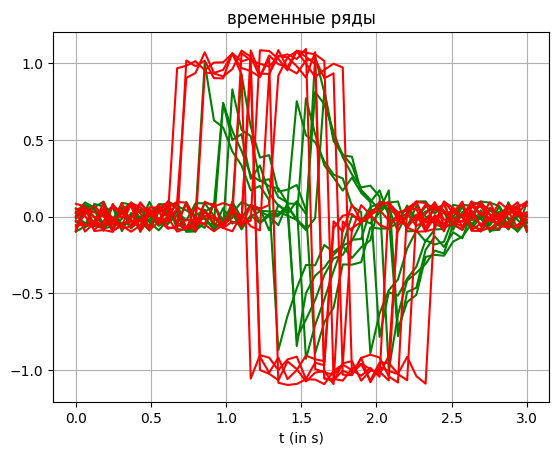

In [3]:
# индекс и отсчет времени в секундах
time_index = np.linspace(0, 3, 50)

tseries_list = {'Time': time_index}

serieses = []
lables = [0]*10
lables.extend([1]*10)

N = 10 #количество образцов в каждом типе сигналов

for i in range(N):
    temp = esp(time_index - np.random.random() - 1/2)
    tseries_list["Te"+str(i)]= temp
    serieses.append(temp)

# пульс сигнал
for i in range(N):
    temp = pulse(time_index - np.random.random() - 1/2)
    tseries_list["Tp"+str(i)]= temp
    serieses.append(temp)


for i in range(N):
    plt.plot(time_index, tseries_list["Te"+str(i)], '-g')
for i in range(N):
    plt.plot(time_index, tseries_list["Tp"+str(i)], '-r')

plt.title(r'временные ряды')
plt.xlabel(r't (in s)')
plt.grid()

In [4]:
def normilize(R):
    m = np.mean(R)
    s = np.std(R)
    if s > 0.00001:
        res = (R-m)/s
    else:
        res = R - m
    return res

In [5]:
def dist(R,L):
    R = normilize(R)
    L = normilize(L)
    S = R - L
    S = S*S
    res = np.sum(S)
    return res


In [6]:
def extract_subsequnces(T,L):
    res = []
    for i in range(len(T)-L+1):
        res.append(T[i:i+L])
    return res

In [7]:
def dist_series(R,T):
    W = extract_subsequnces(T,len(R))
    d = np.zeros(len(W))
    for i,j in enumerate(W):
        d[i] = dist(R,j)
    res = np.min(d)
    return res

In [8]:
def entropy(T):
    n = len(T)
    if n != 0:
        ones = np.sum(T)
        zeros = n - ones
        res = 0
        if zeros != 0:
            res += -zeros/n*np.log(zeros/n)
        if ones != 0:
            res += -ones/n*np.log(ones/n)
    else:
        res = 0
    return res

In [9]:
def calc_quality(Ds,lables):
    temp = list(zip(Ds,lables))
    temp = sorted(temp,key=lambda x: x[0])
    labels = np.array([i[1] for i in temp])
    igs = np.zeros(len(labels))
    base = entropy(labels)
    n = len(labels)
    for i,j in enumerate(temp):
        igs[i] = base - (i/n*entropy(labels[:i]) + (n-i)/n*entropy(labels[i:]))
    res = np.max(igs)
    return res

In [10]:
def remove_similar(shapelets):
    flags = [True]*len(shapelets)
    for i in range(len(shapelets)):
        for j in range(i+1,len(shapelets)):
            if dist(shapelets[i][0],shapelets[j][0]) < 0.00001:
                flags[i] = False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            shapelets.pop(i)
    return shapelets

In [11]:
def remove_similar_2(shapelets):
    flags = [True]*len(shapelets)
    for i in range(len(shapelets)):
        for j in range(i+1,len(shapelets)):
            if dist(shapelets[i],shapelets[j]) < 0.00001:
                flags[i] = False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            shapelets.pop(i)
    return shapelets

In [12]:
def remove_similar_between_lists_2(shapelets,new_shapelets):
    flags = [True]*len(new_shapelets)
    for i in range(len(new_shapelets)):
        for j in range(len(shapelets)):
            if dist(new_shapelets[i],shapelets[j]) < 0.00001:
                flags[i] = False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            new_shapelets.pop(i)
    return new_shapelets

In [13]:
def add_if_new(shapelets,shap):
    flag = True
    for j in range(len(shapelets)):
            if dist(shap[0],shapelets[j][0]) < 0.0000001:
                flag = False
                break
    if flag:
         shapelets.append(shap)
    return flag

In [14]:
dataset = list(zip(serieses,lables))

random.seed(42)

random.shuffle(dataset)

train = dataset[:16]
test = dataset[16:]

train_serieses = [i[0] for i in train]
train_labels = [i[1] for i in train]
test_serieses = [i[0] for i in test]
test_labels = [i[1] for i in test]

In [15]:
origin_serieses = serieses
origin_lables = lables

In [16]:
serieses = train_serieses
lables = train_labels

In [ ]:
#Ограничения длины шапилетов
min_len = 5
max_len = 25

#Кол-во шапелетов, которое достается из каждого обучающего ряда
p = 5

#найденные шапелеты по длинам
rShapeles = {}
for i in range(min_len,max_len+1):
    rShapeles[i] = []

for d,i in enumerate(serieses):
    print(f"{d+1}/{len(serieses)}")
    shapelets = []
    #Достаем все шапелеты из ряда и оцениваем их
    for j in range(min_len,max_len+1):
        sh_same_lenght = []
        W = extract_subsequnces(i,j)
        for k in W:
            Ds = np.zeros(len(serieses))
            for z,f in enumerate(serieses):
                Ds[z] = dist_series(k,f)
            quality = calc_quality(Ds,lables)
            sh_same_lenght.append((k,quality))
        #Удаляем потворы
        sh_same_lenght = remove_similar(sh_same_lenght)
        shapelets.extend(sh_same_lenght)
    #Сортируем шапелеты по качеству и добавляем только p лучших (если они уже не добавлены из прошлых рядов)
    shapelets = sorted(shapelets,key=lambda x: x[1],reverse=True)
    s = 0
    j = 0
    while j < len(shapelets) and s < p:
        if add_if_new(rShapeles[len(shapelets[j][0])],shapelets[j]):
            s += 1
        j += 1

SH = list(rShapeles.values())


In [23]:
SH = []
qualities = []

for i in rShapeles.keys():
    for j in rShapeles[i]:
        SH.append(j[0])
        qualities.append(j[1])

In [27]:
def constract_features_vector(T,shapelets):
    D = np.zeros(len(shapelets))
    for i in range(len(shapelets)):
        D[i] = dist_series(shapelets[i],T)
    return D

In [32]:
train_features = [constract_features_vector(i,SH) for i in train_serieses]
test_features = [constract_features_vector(i,SH) for i in test_serieses]

In [51]:
clf = RandomForestClassifier(30)
clf.fit(train_features,train_labels)

RandomForestClassifier(n_estimators=30)

In [60]:
print("Итоги обучения")
print(f"Train accuracy={clf.score(train_features,train_labels)}")
print(f"test accuracy={clf.score(test_features,test_labels)}")
print(f"Train labels={train_labels}, train predict={clf.predict(train_features)}, test labels={test_labels}, test predict={clf.predict(test_features)}")

Итоги обучения
Train accuracy=1.0
test accuracy=1.0
Train labels=[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1], train predict=[1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1], test labels=[0, 0, 0, 0], test predict=[0 0 0 0]


In [61]:
print("Найденные шапелеты и их IG")
for i in zip(SH,qualities):
    print(f"shapelet={i[0]} IG={i[1]}")

Найденные шапелеты и их IG
shapelet=[-0.05171461 -0.07794292 -0.07097174  0.94008739  0.93383487] IG=0.6615632381579821
shapelet=[-0.07097174  0.94008739  0.93383487  0.91364247  0.96222883] IG=0.6615632381579821
shapelet=[ 0.91026306  1.02958488 -1.08425082 -1.09811111 -1.09201327] IG=0.6615632381579821
shapelet=[ 1.02958488 -1.08425082 -1.09811111 -1.09201327 -1.06154001] IG=0.6615632381579821
shapelet=[-0.96546104 -0.07559064 -0.03525606  0.01049668 -0.0536091 ] IG=0.6615632381579821
shapelet=[0.82271861 0.51416028 0.40686558 0.33351876 0.1741699 ] IG=0.6615632381579821
shapelet=[0.40686558 0.33351876 0.1741699  0.11012806 0.04173168] IG=0.6615632381579821
shapelet=[ 0.9690093   0.94931347 -0.91442856 -1.01820841 -0.92026325] IG=0.6615632381579821
shapelet=[ 0.94931347 -0.91442856 -1.01820841 -0.92026325 -1.06022916] IG=0.6615632381579821
shapelet=[-0.93078252 -0.94341135 -0.03159472 -0.09760796  0.07810129] IG=0.6615632381579821
shapelet=[0.06603216 0.03858309 0.03341856 0.03330529